In [1]:
import os
from copy import deepcopy
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem
from tqdm.contrib.concurrent import thread_map

datasets = {'c-binding': 'Protein-peptide binding affinity (canonical)',
        'c-cpp': 'Cell penetration (canonical)',
        'nc-binding': 'Protein-peptide binding affinity (non-canonical)',
        'nc-cpp': 'Cell penetration (non-canonical)',
        # 'c-sol': 'Solubility (natural)',
        'nc-antibacterial': "Antibacterial (non-canonical)",
        'c-antibacterial': "Antibacterial (canonical)",
        'nc-antiviral': "Antiviral (non-canonical)",
        'c-antiviral': "Antiviral (canonical)"}
datasets_sim = ['c-binding', 'nc-binding', 'c-cpp', 'nc-cpp', 'c-antibacterial', 'nc-antibacterial',
                'c-antiviral', 'nc-antiviral']
# datasets_sim.remove('nc-cpp')
# datasets_sim.remove('nc-binding')
# datasets_sim.remove('c-sol')

metrics_class = {
    'acc': 'Accuracy', 'f1_weighted': 'Weighted F1',
    'mcc': 'Matthew\'s correlation coefficient',
    'auroc': "Area under the ROC curve"
}
metrics_reg = {
    'pcc': 'Pearson\'s R', 'spcc': 'Spearman\'s R',
    'rmse': 'RMSE'
}
fancy_rep = {
    'esm2-8m': 'ESM2 8M',
    'esm2-150m': "ESM2 150M",
    'prot-t5-xl': "Prot-T5-XL",
    'molformer': 'Molformer-XL',
    'chemberta': 'ChemBERTa-2',
    'pepfunn': 'PepFuNN',
    # Radius 8 corresponds to diameter 16
    'ecfp': "ECFP-16",
    'pepclm': "PeptideCLM",
    'pepland': "Pepland"
}
metrics_fancy = metrics_class 
metrics_fancy.update(metrics_reg)
REGRESSION = ['c-binding', 'nc-binding']
DPI = 512
sorted(datasets_sim)
print(datasets_sim)

['c-binding', 'nc-binding', 'c-cpp', 'nc-cpp', 'c-antibacterial', 'nc-antibacterial', 'c-antiviral', 'nc-antiviral']


# 1. Similarity function

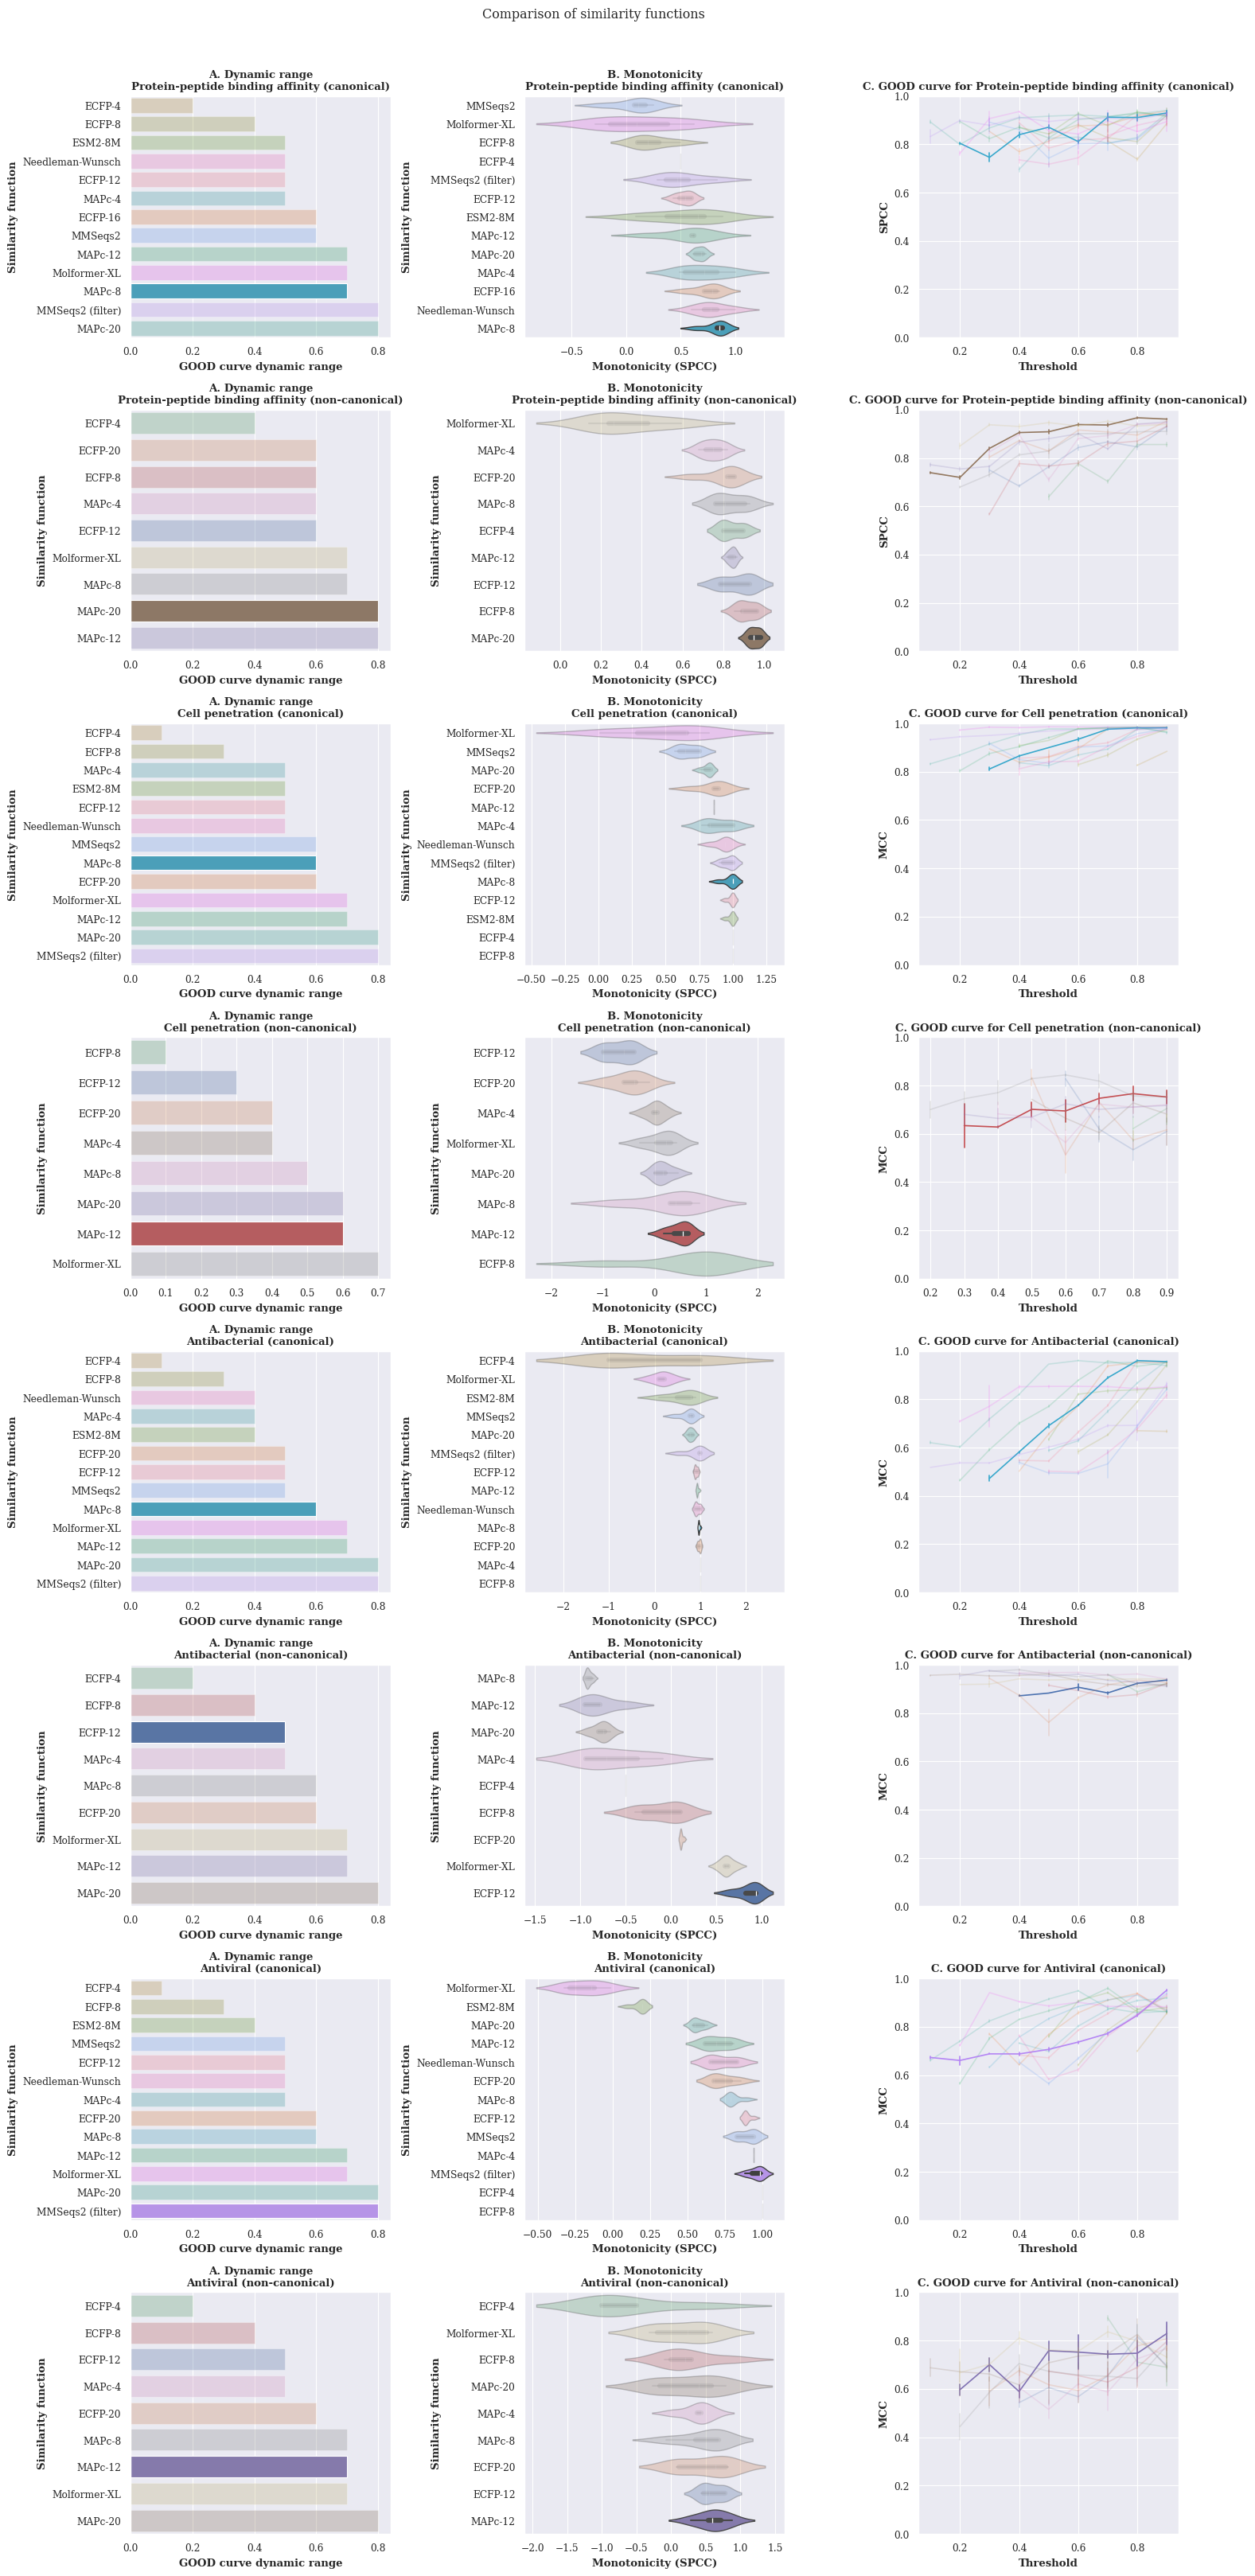

In [3]:
dir = '../../Results/similarity'
model = 'svm'


def fancy_sim(similarity):
    if 'tanimoto' in similarity:
        return  f"ECFP-{int(similarity.split('_')[2])*2}"
    elif 'jaccard' in similarity:
        return f"MAPc-{int(similarity.split('_')[2])*2}"
    elif 'molformer' in similarity:
        return 'Molformer-XL'
    elif 'needle' in similarity:
        return 'Needleman-Wunsch'
    elif 'mmseqs+prefilter' in similarity:
        return "MMSeqs2 (filter)"
    elif 'mmseqs' in similarity:
        return "MMSeqs2"
    elif 'peptides' in similarity:
        return 'Custom MMSeqs2'
    elif 'esm2' in similarity:
        return 'ESM2-8M'


df = pd.DataFrame()

for file in os.listdir(dir):
    if 'peptides' in file:
        continue
    if 'c-sol' in file:
        continue

    path = os.path.join(dir, file)
    tmp_df = pd.read_csv(path)
    tmp_df['model'] = file.split('_')[1]
    tmp_df['distance'] = file.split('_')[2]
    tmp_df['fp'] = file.split('_')[3]
    tmp_df['radius'] = file.split('_')[4]
    dataset = file.split('_')[0]
    tmp_df['dataset'] = dataset
    tmp_df['similarity'] = '_'.join(file.split('_')[2:5])
    df = pd.concat([df, tmp_df])
    df = df[df.threshold != 'random']
    df = df[(df.threshold.map(float) * 100) % 10 == 0]
    df.threshold = df.threshold.map(float)
df = df[df.threshold > 0.05]
all_df = df.copy()
all_df['similarity'] = all_df.similarity.map(fancy_sim)

plt.gcf().set_size_inches(15, 4*len(datasets_sim))
sns.set_theme('paper')
plt.rcParams.update({'font.family': 'serif'})
plt.subplots_adjust(top=0.8)
dataset_order = all_df.dataset.unique()

for idx, dataset in enumerate(datasets_sim):
    df = all_df[all_df['dataset'] == dataset].copy()
    result_df = pd.DataFrame()

    if dataset in REGRESSION:
        metric = 'spcc'
    else:
        metric = 'mcc'

    df['threshold'] = df['threshold'].map(float)
    df[metric] = df[metric].map(float)
    similarities = df.similarity.unique()
    monotonicitys = []
    for similarity in similarities:
        tmp_df = df[df['similarity'] == similarity].copy()
        for seed in range(5):
            s_tmp_df = tmp_df[tmp_df.seed == seed]
            performances = s_tmp_df[metric].to_numpy()
            thresholds = s_tmp_df['threshold'].to_numpy()
            a, b = spearmanr(performances, thresholds)
            monotonicitys.append({
                'monotonicity': a,
                'similarity': similarity,
                'dynamic_range': tmp_df[tmp_df.similarity == similarity].threshold.max() - tmp_df[tmp_df.similarity == similarity].threshold.min(),
                'dataset': dataset
            })

    if dataset == 'c-binding':
        sim_i = 8
    elif dataset == 'nc-binding':
        sim_i = 5
    elif dataset == 'c-cpp':
        sim_i = 8
    elif dataset == 'nc-cpp':
        sim_i = 3
    elif dataset == 'nc-antibacterial':
        sim_i = 0
    elif dataset == 'c-antibacterial':
        sim_i = 8
    elif dataset == 'nc-antiviral':
        sim_i = 4
    elif dataset == 'c-antiviral':
        sim_i = 10

    result_df = pd.concat([pd.DataFrame(monotonicitys)])
    result_df.dropna(inplace=True)
    similarities_order = sorted(result_df.similarity.unique())

    with open(f'tables/{dataset}_table.md', 'w') as fo:
        n_df = pd.DataFrame([{
            'Similarity': n,
            'Monotonicity': f"{g_df['monotonicity'].mean():.3g}±{g_df['monotonicity'].std():.1}",
            'Dynamic range': f"{g_df['dynamic_range'].max()*100}"
        } for n, g_df in result_df.groupby('similarity')])
        n_df.sort_values('Dynamic range', ignore_index=True, ascending=False, inplace=True)
        fo.write(n_df.to_latex(index=False))
    num_subplots = 3
    plt.subplot(len(datasets_sim), num_subplots, 1+idx*num_subplots)
    result_df.sort_values('dynamic_range', inplace=True)
    ax = sns.barplot(result_df, x='dynamic_range', y='similarity', hue='similarity',
                     hue_order=similarities_order)

    for i_sim, (patch, g_sim) in enumerate(zip(ax.patches, similarities_order)):
        if sim_i != i_sim:
            patch.set_alpha(0.3)

        # if sim != g_sim:
        #     patch.set_alpha(0.3)

    plt.xlim(0)
    plt.xlabel('GOOD curve dynamic range', fontdict={'weight': 'bold'})
    plt.ylabel('Similarity function', fontdict={'weight': 'bold'})
    plt.title(f'A. Dynamic range\n{datasets[dataset]}',
                fontdict={'weight': 'bold'})

    plt.subplot(len(datasets_sim), num_subplots, 2+idx*num_subplots)
    # result_df.sort_values('monotonicity', inplace=True)
    means = result_df.groupby('similarity')['monotonicity'].mean()
    names = [n for n, g in result_df.groupby('similarity')]
    order = np.argsort(means)
    names = [names[i] for i in order]
    ax = sns.violinplot(result_df, x='monotonicity', y='similarity',
                   hue='similarity', hue_order=similarities_order,
                   order=names
    )
    if dataset == 'c-binding':
        sim = 11
        l_sim = [34, 35, 36]
    elif dataset == 'c-cpp':
        sim = 8
        l_sim = [26, 27, 28]
    elif dataset == 'nc-binding':
        sim = 8
        l_sim = [25, 26, 27]
    elif dataset == 'nc-antibacterial':
        sim = 7
        l_sim = [22, 23, 24]
    elif dataset == 'c-antibacterial':
        sim = 9
        l_sim = [27, 28, 29]
    elif dataset == 'nc-cpp':
        sim = 6
        l_sim = [18, 19, 20]
    elif dataset == 'nc-antiviral':
        sim = 8
        l_sim = [24, 25, 26]
    elif dataset == 'c-antiviral':
        sim = 10
        l_sim = [30, 31, 32]

    for idx_l, line in enumerate(ax.lines):
        if idx_l not in l_sim:
            line.set_alpha(0.1)
    for idx_c, col in enumerate(ax.collections):
        if idx_c != sim:
            col.set_alpha(0.3)

    plt.ylabel('Similarity function', fontdict={'weight': 'bold'})
    plt.xlabel("Monotonicity (SPCC)", fontdict={'weight': 'bold'})
    plt.title(f'B. Monotonicity\n{datasets[dataset]}',
                fontdict={'weight': 'bold'})
    new_df = pd.DataFrame()
    for i, i_df in enumerate(result_df.similarity.unique()):
        t_df = df[df.similarity == i_df].copy()
        new_df = pd.concat([new_df, t_df])


    plt.subplot(len(datasets_sim), num_subplots, 3+idx*num_subplots)
    plt.title(f'C. GOOD curve for {datasets[dataset]}', fontdict={"weight": "bold"})
    ax = sns.lineplot(new_df, x='threshold', y=metric, hue='similarity',
                 hue_order=similarities_order,
                 errorbar='se', err_style='bars', n_boot=1000)
    sim = sim_i
    l_sim = sim_i * 2
    
    for idx_c, col in enumerate(ax.collections):
        if idx_c != sim:
            col.set_alpha(0.2)

    for i_l, line in enumerate(ax.lines):
        if i_l != l_sim:
            line.set_alpha(0.2)
    plt.legend().set_visible(False)
    plt.ylabel(metric.upper(), fontdict={"weight": "bold"})
    plt.xlabel('Threshold', fontdict={'weight': "bold"})
    plt.ylim(0, 1)

plt.suptitle(f'Comparison of similarity functions', y=1.01)
plt.tight_layout()
plt.savefig(f'si_figures/sim_metric.png', dpi=DPI, bbox_inches='tight')
# plt.show()

# 2. Cleaner rep analysis

/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/ipykernel_2998/1438152154.py:79: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(new_df, x='GOOD', y='rep', hue='model',
/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/ipykernel_2998/1438152154.py:79: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(new_df, x='GOOD', y='rep', hue='model',
/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/ipykernel_2998/1438152154.py:79: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(new_df, x='GOOD', y='rep', hue='model',
/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/ipykernel_2998/1438152154.py:79: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(new_df, x='GOOD', y='rep', hue='model',
/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/ipykern

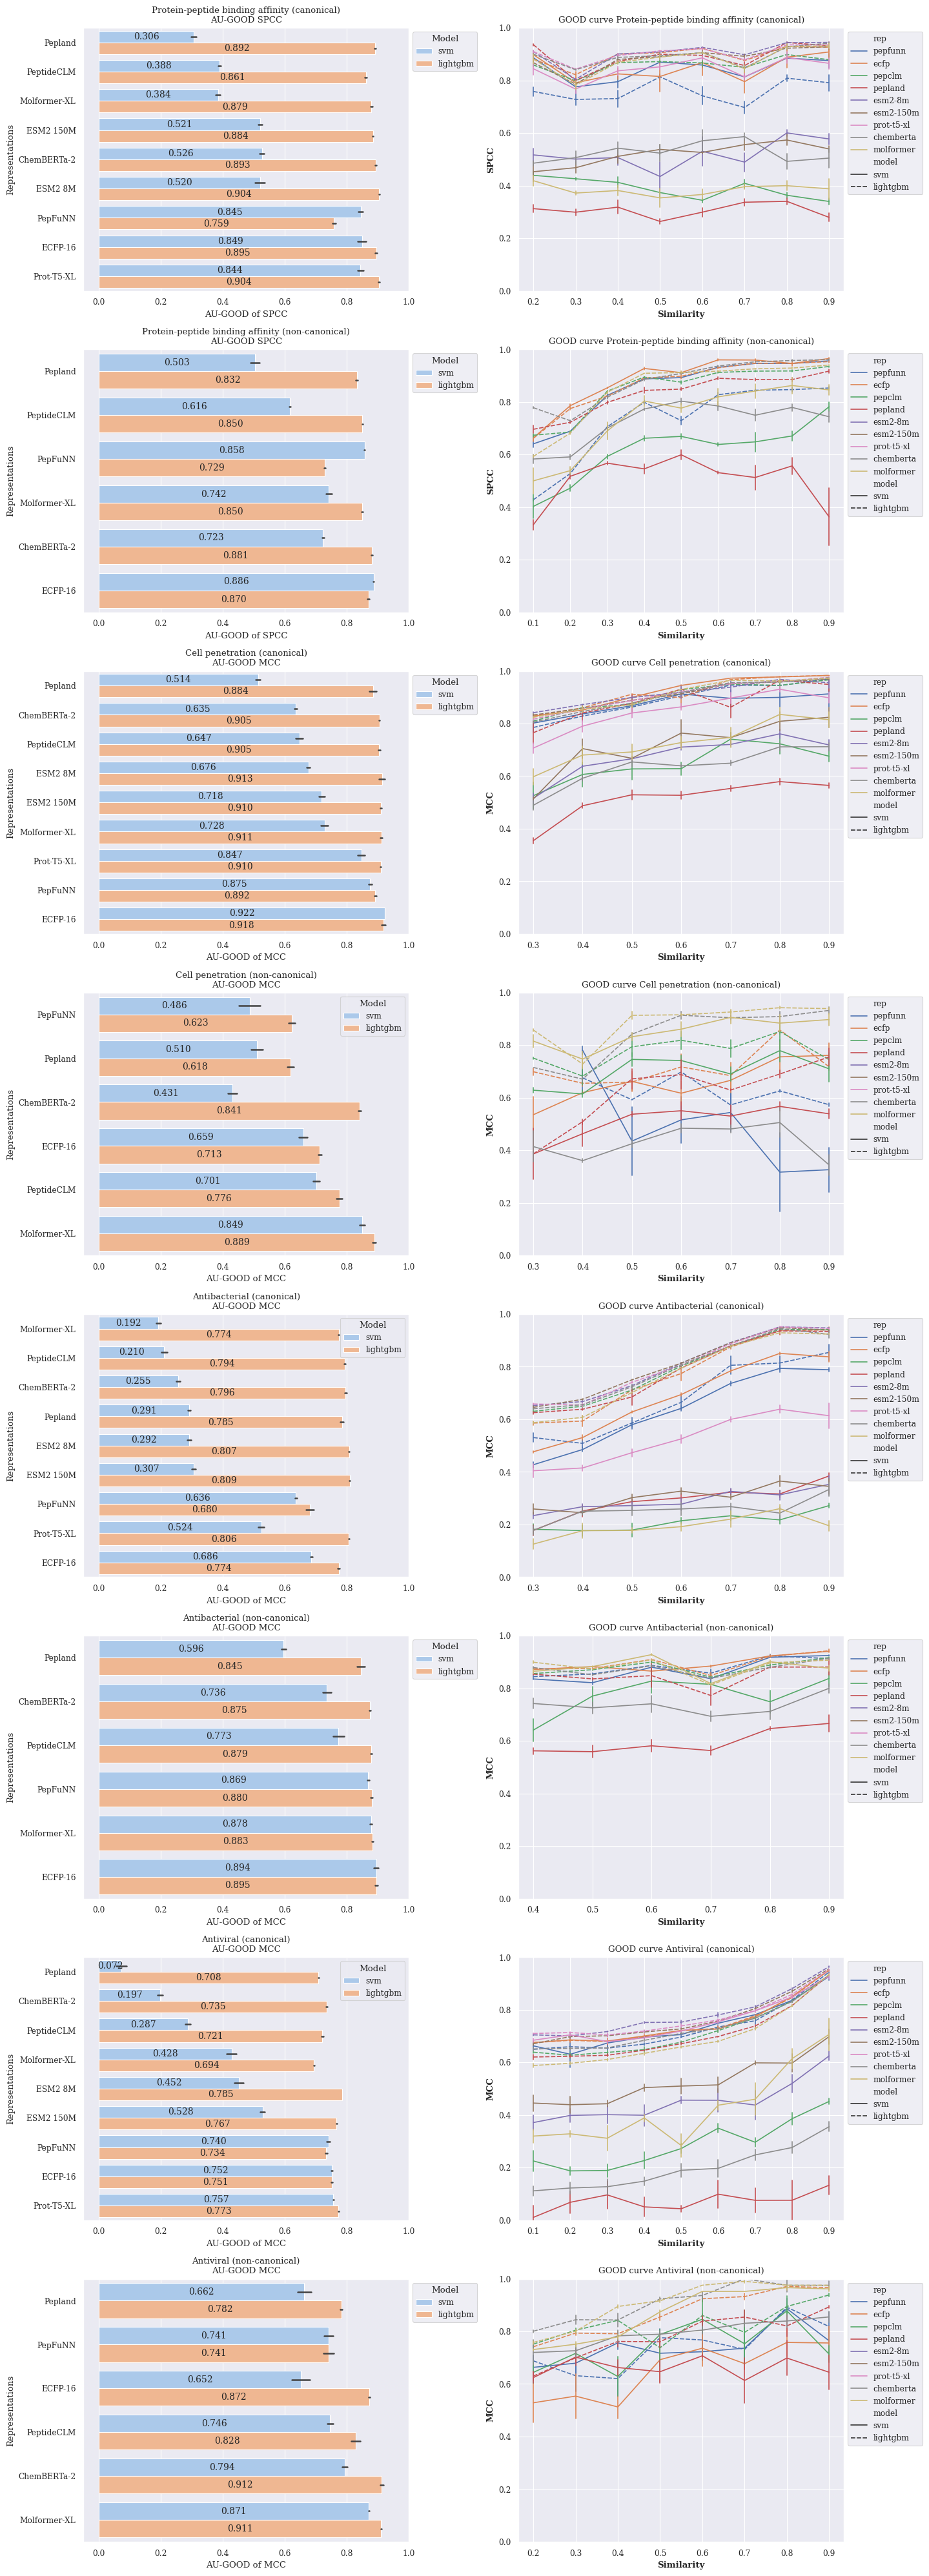

In [4]:
dir = '../../Results/representations'
# combinations = [sim_metric + ' - ' + fp
#                 for sim_metric in SIM_METRICS_FANCY
#                 for fp in FINGERPRINTS_FANCY] + ['MAPc - Jaccard']
df = pd.DataFrame()

for file in os.listdir(dir):
    if 'mmseqs' in file:
        print(file)
        continue
    path = os.path.join(dir, file)
    tmp_df = pd.read_csv(path)
    tmp_df['model'] = file.split('_')[1]
    tmp_df['pre_pca'] = float(file.split('_')[3])
    tmp_df['post_pca'] = float(file.split('_')[5])
    tmp_df['dataset'] = file.split('_')[0]
    tmp_df['rep'] = file.split('_')[6][:-4]

    df = pd.concat([df, tmp_df])
    df = df[df.threshold != 'random']
df.threshold = df.threshold.map(float)
df = df[df.threshold > 0.05]

all_df = df.copy()

# all_df = all_df[all_df['model'] == model]
plt.gcf().set_size_inches(20, 5.*len(datasets_sim))
sns.set_theme('paper')
plt.rcParams.update({'font.family': 'serif'})
plt.subplots_adjust(top=0.8)
reps_order = all_df.rep.unique()
dataset_order = ['c-binding', 'nc-binding', 'c-cpp', 'nc-cpp', 'c-antibacterial',
                 'nc-antibacterial', 'c-antiviral', 'nc-antiviral']

all_proto_df = []
for idx, dataset in enumerate(dataset_order):
    df = all_df[all_df['dataset'] == dataset].copy()
    # print(dataset)
    if dataset in REGRESSION:
        metric = 'spcc'
    else:
        metric = 'mcc'
    num_subplots = 3
    new_df = []
    for model in all_df.model.unique():
        for seed in all_df.seed.unique():
            for rep in all_df.rep.unique():
                tmp_df = df[(df.model == model) & (df.seed == seed) & (df.rep == rep)]
                if len(tmp_df) < 1:
                    continue
                new_df.append(
                    {'rep': rep, 'seed': seed, 'model': model, 'GOOD': tmp_df[metric].mean(),
                     'dataset': dataset}
                )
                all_proto_df.append(new_df[-1])
    new_df = pd.DataFrame(new_df)
    fancy_rep = {
        'esm2-8m': 'ESM2 8M',
        'esm2-150m': "ESM2 150M",
        'prot-t5-xl': "Prot-T5-XL",
        'molformer': 'Molformer-XL',
        'chemberta': 'ChemBERTa-2',
        'pepfunn': 'PepFuNN',
        # Radius 8 corresponds to diameter 16
        'ecfp': "ECFP-16",
        'pepclm': "PeptideCLM",
        'pepland': "Pepland"
    }

    new_df.rep = new_df.rep.map(fancy_rep)
    means = new_df.groupby('rep')['GOOD'].mean()
    names = [n for n, g in new_df.groupby('rep')]
    order = np.argsort(means)
    names = [names[i] for i in order]

    order = []
    plt.subplot(len(datasets_sim), num_subplots, 1+idx*num_subplots)
    plt.title(f'{datasets[dataset]}\nAU-GOOD {metric.upper()}')
    ax = sns.barplot(new_df, x='GOOD', y='rep', hue='model',
                     errorbar='se', order=names, palette=sns.color_palette('pastel'))
    plt.xlim(-0.05, 1)
    plt.xlabel(f"AU-GOOD of {metric.upper()}")
    plt.ylabel("Representations")

    ax.bar_label(ax.containers[0], fontsize=10, label_type='center', fmt='%.3f')
    if len(ax.containers) > 1:        
        ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.3f')
    plt.legend(title='Model', bbox_to_anchor=(1, 1))

    plt.subplot(len(datasets_sim), num_subplots, 2+idx*num_subplots)
    plt.title(f'GOOD curve {datasets[dataset]}')
    ax = sns.lineplot(df, x='threshold', y=metric, hue='rep',
                     style='model', err_style='bars',
                     errorbar='se', style_order=['svm', 'lightgbm'],
                     hue_order=['pepfunn', 'ecfp', 'pepclm',  'pepland',
                                'esm2-8m', 'esm2-150m', 'prot-t5-xl',
                                'chemberta', 'molformer'])
    plt.ylabel(metric.upper(), fontdict={"weight": "bold"})
    plt.xlabel("Similarity", fontdict={"weight": "bold"})
    plt.ylim(0, 1.)
    plt.legend(bbox_to_anchor=(1, 1))
    # ax.bar_label(ax.containers[0], fontsize=10, label_type='center', fmt='%.3f')
    # if len(ax.containers) > 1:        
        # ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.3f')

plt.tight_layout()
plt.savefig('si_figures/all_reps.png', dpi=DPI, bbox_inches='tight')
    # plt.legend(bbox_to_anchor=(1., 1.0))

    # plt.ylim(0, 1)
    # plt.subplot(len(datasets_sim), num_subplots, 2+idx*num_subplots)
    # plt.title(f'GOOD curve {datasets[dataset]}')
    # sns.lineplot(df[~df[metric].isna()], x='threshold', y=metric, hue='rep', err_style='bars',
    #              errorbar='se', hue_order=reps_order)
    # plt.ylim(0, 1)

# 3. Statistical analysis LigthGBM

Std LightGBM natural: 0.07257022592119268
Canonical: 0.008029449448240343
There is significant difference between representation methods with canonical datasets
Std LightGBM natural: 0.0854148499150162
Non-canonical: 1.7027403956090142e-07
There is significant difference between representation methods with non-canonical datasets


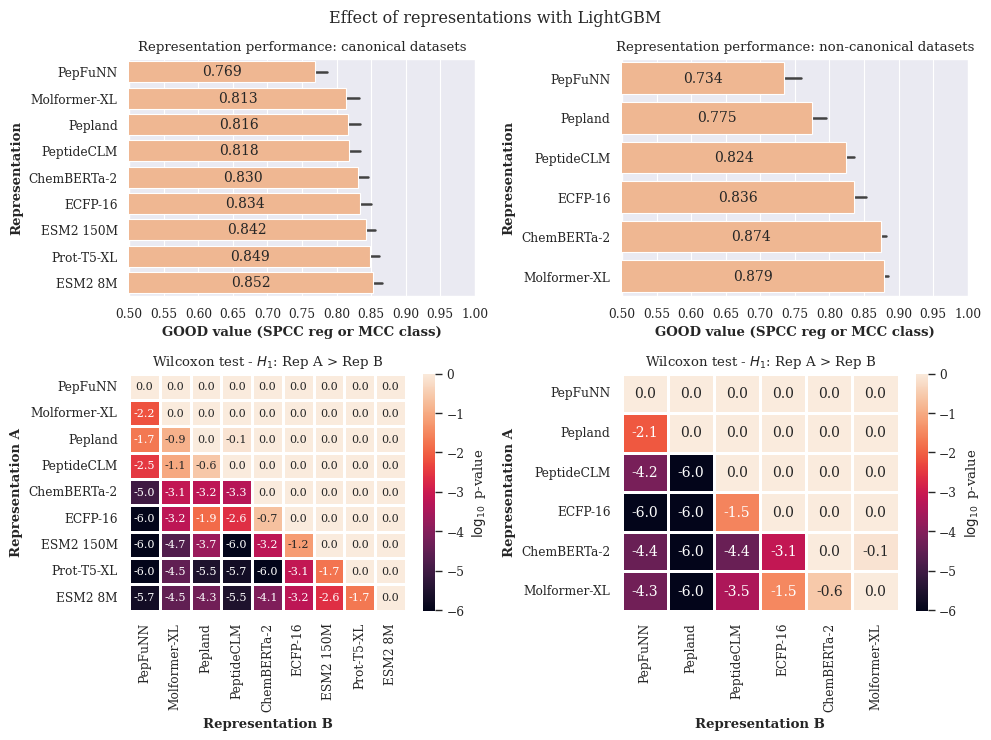

In [5]:
from scipy.stats import kruskal, wilcoxon


def get_stats(df: pd.DataFrame, order: list):
    g_df = df.groupby('rep')
    groups = {}
    for n, mini_df in g_df:
        groups[n] = mini_df['GOOD'].to_numpy()
    names = {name: idx for idx, name in enumerate(order)}
    mtx = np.ones((len(groups), len(groups)))
    for pair1 in order:
        for pair2 in order:
            if pair1 == pair2:
                continue    
            if len(groups[pair1]) != len(groups[pair2]):
                value = 2
            else:
                value = wilcoxon(
                    groups[pair1], groups[pair2],
                    alternative='greater'
                )[1]
            mtx[names[pair1], names[pair2]] = value
    # Bonferroni correction
    # mtx = mtx > 0.05 / len(groups.keys())
    return groups, mtx
dir = '../../Results/representations'
# combinations = [sim_metric + ' - ' + fp
#                 for sim_metric in SIM_METRICS_FANCY
#                 for fp in FINGERPRINTS_FANCY] + ['MAPc - Jaccard']
df = pd.DataFrame()

for file in os.listdir(dir):
    if 'mmseqs' in file:
        print(file)
        continue
    path = os.path.join(dir, file)
    tmp_df = pd.read_csv(path)
    tmp_df['model'] = file.split('_')[1]
    tmp_df['pre_pca'] = float(file.split('_')[3])
    tmp_df['post_pca'] = float(file.split('_')[5])
    tmp_df['dataset'] = file.split('_')[0]
    tmp_df['rep'] = file.split('_')[6][:-4]

    df = pd.concat([df, tmp_df])
    # df = df[df.threshold == 'random']
# df.threshold = df.threshold.map(float)
all_df = df.copy()

# all_df = all_df[all_df['model'] == model]
plt.gcf().set_size_inches(20, 5.*len(datasets_sim))
sns.set_theme('paper')
plt.rcParams.update({'font.family': 'serif'})
plt.subplots_adjust(top=0.8)
reps_order = all_df.rep.unique()
dataset_order = ['c-binding', 'nc-binding', 'c-cpp', 'nc-cpp', 'c-antibacterial',
                 'nc-antibacterial', 'c-antiviral', 'nc-antiviral']

all_proto_df = []
for idx, dataset in enumerate(dataset_order):
    df = all_df[all_df['dataset'] == dataset].copy()
    # print(dataset)
    if dataset in REGRESSION:
        metric = 'spcc'
    else:
        metric = 'mcc'
    num_subplots = 3
    new_df = []
    for model in all_df.model.unique():
        for seed in all_df.seed.unique():
            for rep in all_df.rep.unique():
                tmp_df = df[(df.model == model) & (df.seed == seed) & (df.rep == rep)]
                if len(tmp_df) < 1:
                    continue
                new_df.append(
                    {'rep': rep, 'seed': seed, 'model': model, 'GOOD': tmp_df[metric].mean(),
                     'dataset': dataset}
                )
                all_proto_df.append(new_df[-1])

fancy_rep = {
    'esm2-8m': 'ESM2 8M',
    'esm2-150m': "ESM2 150M",
    'prot-t5-xl': "Prot-T5-XL",
    'molformer': 'Molformer-XL',
    'chemberta': 'ChemBERTa-2',
    'pepfunn': 'PepFuNN',
    # Radius 8 corresponds to diameter 16
    'ecfp': "ECFP-16",
    'pepclm': "PeptideCLM",
    'pepland': "Pepland"
}

df = pd.DataFrame(all_proto_df)
df.rep = df.rep.map(fancy_rep)
df = df[df.model == 'lightgbm']
all_df = df[df.dataset.map(lambda x: x.startswith("c-"))]
means = all_df.groupby('rep')['GOOD'].mean()
names = [n for n, g in all_df.groupby('rep')]
order = np.argsort(means)
names = [names[i] for i in order]

plt.gcf().set_size_inches(10, 7.5)
sns.set_theme('paper')
plt.rcParams.update({'font.family': 'serif'})
plt.subplots_adjust(top=0.8)

plt.subplot(2, 2, 1)
x_svm = all_df['GOOD'].std()
print("Std LightGBM natural:", x_svm)
plt.title('Representation performance: canonical datasets')
ax = sns.barplot(all_df, x='GOOD', y='rep', hue='model',
                 order=names, palette=[sns.color_palette('pastel')[1]],
                    errorbar='se',
                    zorder=3
                    # whis=(0, 100),
                    )
                    
plt.xlabel(f"GOOD value (SPCC reg or MCC class)",
           fontdict={"weight": "bold"})
plt.ylabel(f'Representation',
           fontdict={"weight": "bold"})
plt.xlim(0.5, 1)
try:
    ax.bar_label(ax.containers[0], fontsize=10, label_type='center', fmt='%.3f')
    if len(ax.containers) > 1:        
        ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.3f')
    # plt.legend(title='Model', bbox_to_anchor=(1, 1))

except:
    pass

ax.get_legend().remove()

plt.locator_params(axis='x', nbins=10)


plt.subplot(2, 2, 3)
groups, mtx = get_stats(all_df, names)
# Kruskal-Wallis test
p_value = kruskal(*list(groups.values()))[1]
print(f"Canonical: {p_value}")
if p_value > 0.05:
    print("There is no difference between representation methods with canonical datasets")
    mtx = None
else:
    print("There is significant difference between representation methods with canonical datasets")

    mtx = np.log10(mtx)
    mtx[mtx > -0.1] = 0
    sns.heatmap(mtx, xticklabels=names,
                yticklabels=names,
                annot=True, cbar=True,
                cbar_kws={'label': r'$\log_{10}$ p-value'},
                annot_kws={"size": 8},
                linewidths=1,
                fmt=".1f")
psig = 0.05 / len(names)

plt.ylabel('Representation A',
           fontdict={"weight": "bold"})
plt.xlabel('Representation B',
           fontdict={"weight": "bold"})
plt.xticks(rotation=90)
plt.title(r"Wilcoxon test - $H_1$: Rep A > Rep B")

all_df = df[df.dataset.map(lambda x: x.startswith("nc-"))]
# all_df = all_df[all_df.rep != 'PepFunn']
means = all_df.groupby('rep')['GOOD'].mean()
names = [n for n, g in all_df.groupby('rep')]
order = np.argsort(means)
names = [names[i] for i in order]

plt.subplot(2, 2, 2)
plt.title('Representation performance: non-canonical datasets')
x_svm = all_df['GOOD'].std()
print("Std LightGBM natural:", x_svm)
ax = sns.barplot(all_df, x='GOOD', y='rep', hue='model',
                 order=names, palette=[sns.color_palette('pastel')[1]],
                    errorbar='se',
                    zorder=3
                    # whis=(0, 100),
                    )
plt.xlabel(f"GOOD value (SPCC reg or MCC class)",
           fontdict={"weight": "bold"})
plt.ylabel(f'Representation',
           fontdict={"weight": "bold"})
plt.xlim(0.5, 1)
try:
    ax.bar_label(ax.containers[0], fontsize=10, label_type='center', fmt='%.3f')
    if len(ax.containers) > 1:        
        ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.3f')
    # plt.legend(title='Model', bbox_to_anchor=(1, 1))

except:
    pass

ax.get_legend().remove()

plt.locator_params(axis='x', nbins=10)

# all_df = all_df[all_df.rep != 'PepFunn']
# all_df = all_df[all_df.rep != 'Pepland']
# names.remove('PepFunn')
# names.remove('Pepland')

groups, mtx = get_stats(all_df, names)
# Kruskal-Wallis test
p_value = kruskal(*list(groups.values()))[1]
print(f"Non-canonical: {p_value}")
if p_value > 0.05:
    print("There is no difference between representation methods with non-canonical datasets")

else:
    print("There is significant difference between representation methods with non-canonical datasets")
    plt.subplot(2, 2, 4)
    mtx = np.log10(mtx)
    mtx[mtx > -0.1] = 0
    sns.heatmap(mtx, xticklabels=names,
                yticklabels=names,
                annot=True, cbar=True,
                cbar_kws={'label': r'$\log_{10}$ p-value'},
                annot_kws={"size": 10},
                linewidths=1,
                fmt=".1f")
    plt.ylabel('Representation A',
            fontdict={"weight": "bold"})
    plt.xlabel('Representation B',
            fontdict={"weight": "bold"})
    plt.xticks(rotation=90)
    plt.title(r"Wilcoxon test - $H_1$: Rep A > Rep B")

plt.suptitle('Effect of representations with LightGBM')
plt.tight_layout()
plt.savefig('figures/rep_effect_lightgbm.png', dpi=DPI, bbox_inches='tight')

# 4. Statistical analysis using SVM

Std SVM canonical: 0.23106309731920077
Canonical: 2.842096288936179e-19
There is significant difference between representation methods with canonical datasets
Std SVM non-canonical: 0.1378686112339482
Non-canonical: 2.3215089928174315e-08
There is significant difference between representation methods with modified datasets


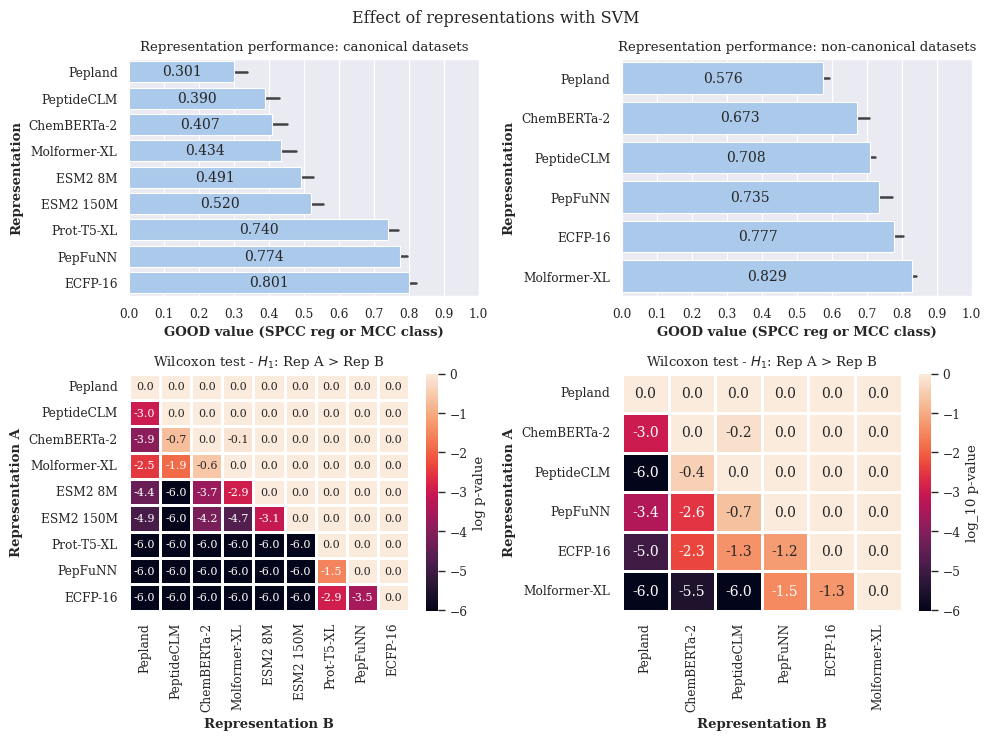

In [6]:
from scipy.stats import kruskal, kruskal, wilcoxon
import matplotlib.patches as mpatches

def get_stats(df: pd.DataFrame, order: list):
    g_df = df.groupby('rep')
    groups = {}
    for n, mini_df in g_df:
        groups[n] = mini_df['GOOD'].to_numpy()
    names = {name: idx for idx, name in enumerate(order)}
    mtx = np.ones((len(groups), len(groups)))
    for pair1 in order:
        for pair2 in order:
            if pair1 == pair2:
                continue    
            if len(groups[pair1]) != len(groups[pair2]):
                value = 2
            else:
                value = wilcoxon(
                    groups[pair1], groups[pair2],
                    alternative='greater'
                )[1]
            mtx[names[pair1], names[pair2]] = value
    # Bonferroni correction
    # mtx = mtx > 0.05 / len(groups.keys())
    return groups, mtx


fancy_rep = {
    'esm2-8m': 'ESM2 8M',
    'esm2-150m': "ESM2 150M",
    'prot-t5-xl': "Prot-T5-XL",
    'molformer': 'Molformer-XL',
    'chemberta': 'ChemBERTa-2',
    'pepfunn': 'PepFuNN',
    # Radius 8 corresponds to diameter 16
    'ecfp': "ECFP-16",
    'pepclm': "PeptideCLM",
    'pepland': "Pepland"
}

df = pd.DataFrame(all_proto_df)
df.rep = df.rep.map(fancy_rep)
df = df[df.model == 'svm']
all_df = df[df.dataset.map(lambda x: x.startswith("c-"))]
means = all_df.groupby('rep')['GOOD'].mean()
names = [n for n, g in all_df.groupby('rep')]
order = np.argsort(means)
names = [names[i] for i in order]

plt.gcf().set_size_inches(10, 7.5)
sns.set_theme('paper')
plt.rcParams.update({'font.family': 'serif'})
plt.subplots_adjust(top=0.8)

plt.subplot(2, 2, 1)
plt.title('Representation performance: canonical datasets')
x_svm = all_df['GOOD'].std()
print("Std SVM canonical:", x_svm)
ax = sns.barplot(all_df, x='GOOD', y='rep', hue='model',
                 order=names, palette=[sns.color_palette('pastel')[0]],
                    errorbar='se',
                    zorder=3
                    # whis=(0, 100),
                    )
plt.xlabel(f"GOOD value (SPCC reg or MCC class)",
           fontdict={"weight": "bold"})
plt.ylabel(f'Representation',
           fontdict={"weight": "bold"})
plt.xlim(0., 1)
try:
    ax.bar_label(ax.containers[0], fontsize=10, label_type='center', fmt='%.3f')
    if len(ax.containers) > 1:        
        ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.3f')
    # plt.legend(title='Model', bbox_to_anchor=(1, 1))

except:
    pass

ax.get_legend().remove()

plt.locator_params(axis='x', nbins=10)


plt.subplot(2, 2, 3)
groups, mtx = get_stats(all_df, names)
# Kruskal-Wallis test
p_value = kruskal(*list(groups.values()))[1]
print(f"Canonical: {p_value}")
if p_value > 0.05:
    print("There is no difference between representation methods with canonical datasets")
    mtx = None
else:
    print("There is significant difference between representation methods with canonical datasets")

    mtx = np.log10(mtx)
    mtx[mtx > -0.1] = 0
    sns.heatmap(mtx, xticklabels=names,
            yticklabels=names,
            annot=True,
            cbar=True,
            cbar_kws={'label': 'log p-value'},
            annot_kws={"size": 8},
            linewidths=1,
            fmt=".1f")
psig = 0.05 / len(names)

plt.ylabel('Representation A',
           fontdict={"weight": "bold"})
plt.xlabel('Representation B',
           fontdict={"weight": "bold"})
plt.xticks(rotation=90)
plt.title(r"Wilcoxon test - $H_1$: Rep A > Rep B")

all_df = df[df.dataset.map(lambda x: x.startswith("nc-"))]
means = all_df.groupby('rep')['GOOD'].mean()
names = [n for n, g in all_df.groupby('rep')]
order = np.argsort(means)
names = [names[i] for i in order]
x_svm = all_df['GOOD'].std()
print("Std SVM non-canonical:", x_svm)
plt.subplot(2, 2, 2)
plt.title('Representation performance: non-canonical datasets')
ax = sns.barplot(all_df, x='GOOD', y='rep', hue='model',
                 order=names, palette=[sns.color_palette('pastel')[0]],
                    errorbar='se',
                    zorder=3
                    # whis=(0, 100),
                    )
plt.xlabel(f"GOOD value (SPCC reg or MCC class)",
           fontdict={"weight": "bold"})
plt.ylabel(f'Representation',
           fontdict={"weight": "bold"})
plt.xlim(0., 1)
try:
    ax.bar_label(ax.containers[0], fontsize=10, label_type='center', fmt='%.3f')
    if len(ax.containers) > 1:        
        ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.3f')
    # plt.legend(title='Model', bbox_to_anchor=(1, 1))

except:
    pass

ax.get_legend().remove()

plt.locator_params(axis='x', nbins=10)

# all_df = all_df[all_df.rep != 'PepFunn']
# names.remove('PepFunn')

groups, mtx = get_stats(all_df, names)
# Kruskal-Wallis test
p_value = kruskal(*list(groups.values()))[1]
print(f"Non-canonical: {p_value}")
if p_value > 0.05:
    print("There is no difference between representation methods with modified datasets")

else:
    print("There is significant difference between representation methods with modified datasets")
    plt.subplot(2, 2, 4)
    mtx = np.log10(mtx)
    mtx[mtx > -0.1] = 0
    sns.heatmap(mtx, xticklabels=names,
                yticklabels=names,
                annot=True, cbar=True,
                cbar_kws={'label': r'log_10 p-value'},
                annot_kws={"size": 10},
                linewidths=1,
                fmt=".1f")
    plt.ylabel('Representation A',
            fontdict={"weight": "bold"})
    plt.xlabel('Representation B',
            fontdict={"weight": "bold"})
    plt.xticks(rotation=90)
    plt.title(r"Wilcoxon test - $H_1$: Rep A > Rep B")

plt.suptitle('Effect of representations with SVM')
plt.tight_layout()
plt.savefig('figures/rep_effect_svm.png', dpi=DPI, bbox_inches='tight')

# 6. Combination representations LightGBM

0.9236250379327146
There is no difference between representation methods with canonical datasets
0.31915265307374685
There is no difference between representation methods with non-canonical datasets


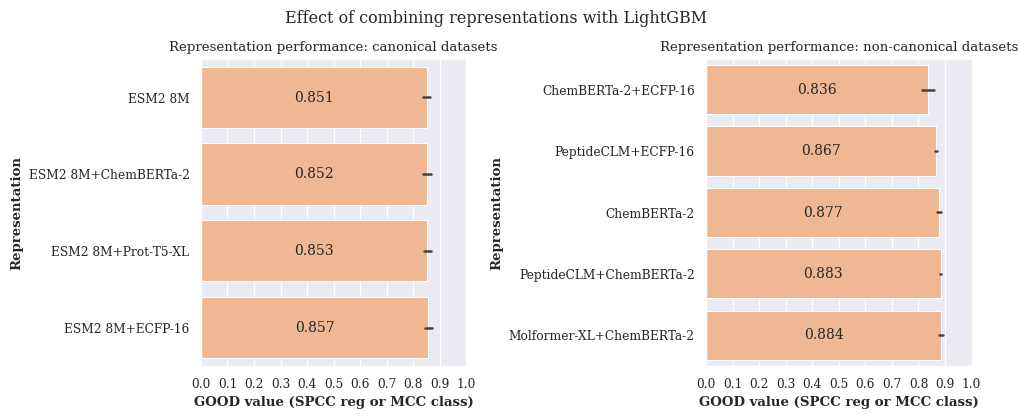

In [7]:
from scipy.stats import kruskal, kruskal, wilcoxon
import matplotlib.patches as mpatches

dir = '../../Results/combinations'
# combinations = [sim_metric + ' - ' + fp
#                 for sim_metric in SIM_METRICS_FANCY
#                 for fp in FINGERPRINTS_FANCY] + ['MAPc - Jaccard']
df = pd.DataFrame()

for file in os.listdir(dir):
    if 'mmseqs' in file:
        print(file)
        continue
    path = os.path.join(dir, file)
    tmp_df = pd.read_csv(path)
    tmp_df['model'] = file.split('_')[1]
    tmp_df['pre_pca'] = float(file.split('_')[3])
    tmp_df['post_pca'] = float(file.split('_')[5])
    tmp_df['dataset'] = file.split('_')[0]
    tmp_df['rep'] = file.split('_')[6][:-4]

    df = pd.concat([df, tmp_df])
    df = df[df.threshold != 'random']
df.threshold = df.threshold.map(float)
all_df = df.copy()

all_proto_df = []
for idx, dataset in enumerate(dataset_order):
    df = all_df[all_df['dataset'] == dataset].copy()
    # print(dataset)
    if dataset in REGRESSION:
        metric = 'spcc'
    else:
        metric = 'mcc'
    num_subplots = 3
    new_df = []
    for model in all_df.model.unique():
        for seed in all_df.seed.unique():
            for rep in all_df.rep.unique():
                tmp_df = df[(df.model == model) & (df.seed == seed) & (df.rep == rep)]
                if len(tmp_df) < 1:
                    continue
                new_df.append(
                    {'rep': rep, 'seed': seed, 'model': model, 'GOOD': tmp_df[metric].mean(),
                     'dataset': dataset}
                )
                all_proto_df.append(new_df[-1])

df = pd.DataFrame(all_proto_df)


def get_stats(df: pd.DataFrame, order: list):
    g_df = df.groupby('rep')
    groups = {}
    for n, mini_df in g_df:
        groups[n] = mini_df['GOOD'].to_numpy()
    names = {name: idx for idx, name in enumerate(order)}
    mtx = np.ones((len(groups), len(groups)))
    for pair1 in order:
        for pair2 in order:
            if pair1 == pair2:
                continue    
            if len(groups[pair1]) != len(groups[pair2]):
                value = 2
            else:
                value = wilcoxon(
                    groups[pair1], groups[pair2],
                    alternative='greater'
                )[1]
            mtx[names[pair1], names[pair2]] = value
    # Bonferroni correction
    # mtx = mtx > 0.05 / len(groups.keys())
    return groups, mtx


fancy_rep = {
    'esm2-8m': 'ESM2 8M',
    'esm2-8m,ecfp': 'ESM2 8M+ECFP-16',
    'esm2-8m,prot-t5-xl': 'ESM2 8M+Prot-T5-XL',
    'esm2-8m,chemberta': 'ESM2 8M+ChemBERTa-2',
    'pepclm,ecfp': 'PeptideCLM+ECFP-16',
    'chemberta': "ChemBERTa-2",
    'ecfp,chemberta': 'ChemBERTa-2+ECFP-16',
    'pepclm,chemberta': 'PeptideCLM+ChemBERTa-2',
    'molformer,chemberta': "Molformer-XL+ChemBERTa-2"
}

df = df[df.model == 'lightgbm']
df.rep = df.rep.map(fancy_rep)
all_df = df[df.dataset.map(lambda x: x.startswith("c-"))]
means = all_df.groupby('rep')['GOOD'].mean()
names = [n for n, g in all_df.groupby('rep')]
order = np.argsort(means)
names = [names[i] for i in order]

plt.gcf().set_size_inches(10, 7.5)
sns.set_theme('paper')
plt.rcParams.update({'font.family': 'serif',
            })
                    #  'mathtext.default': 'regular'})
plt.subplots_adjust(top=0.8)

plt.subplot(2, 2, 1)
plt.title('Representation performance: canonical datasets')
ax = sns.barplot(all_df, x='GOOD', y='rep', hue='model',
                 order=names, palette=[sns.color_palette('pastel')[1]],
                    errorbar='se',
                    # whis=(0, 100),
                    )
plt.xlabel(f"GOOD value (SPCC reg or MCC class)",
           fontdict={"weight": "bold"})
plt.ylabel(f'Representation',
           fontdict={"weight": "bold"})
plt.xlim(0., 1)
try:
    ax.bar_label(ax.containers[0], fontsize=10, label_type='center', fmt='%.3f')
    if len(ax.containers) > 1:        
        ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.3f')
    # plt.legend(title='Model', bbox_to_anchor=(1, 1))

except:
    pass

ax.get_legend().remove()

plt.locator_params(axis='x', nbins=10)


groups, mtx = get_stats(all_df, names)
# Kruskal-Wallis test
p_value = kruskal(*list(groups.values()))[1]
if p_value > 0.05:
    print(p_value)
    print("There is no difference between representation methods with canonical datasets")
    mtx = None
else:
    print("There is significant difference between representation methods with canonical datasets")

if mtx is not None:
    plt.subplot(2, 2, 3)
    mtx = np.log10(mtx)
    mtx[mtx > -0.1] = 0
    print(mtx)
    sns.heatmap(mtx, xticklabels=names,
            yticklabels=names,
            annot=True,
            cbar=True,
            cbar_kws={'label': r'$\log_{10}$ p-value'},
            annot_kws={"size": 8},
            linewidths=1,
            fmt=".1f")
    psig = 0.05 / len(names)

    plt.ylabel('Representation A',
            fontdict={"weight": "bold"})
    plt.xlabel('Representation B',
            fontdict={"weight": "bold"})
    plt.xticks(rotation=90)
    plt.title(r"Wilcoxon test - $H_1$: Rep A > Rep B")

all_df = df[df.dataset.map(lambda x: x.startswith("nc-"))]
means = all_df.groupby('rep')['GOOD'].mean()
names = [n for n, g in all_df.groupby('rep')]
order = np.argsort(means)
names = [names[i] for i in order]

plt.subplot(2, 2, 2)
plt.title('Representation performance: non-canonical datasets')
ax = sns.barplot(all_df, x='GOOD', y='rep', hue='model',
                 order=names, palette=[sns.color_palette('pastel')[1]],
                    errorbar='se',
                    # whis=(0, 100),
                    )
plt.xlabel(f"GOOD value (SPCC reg or MCC class)",
           fontdict={"weight": "bold"})
plt.ylabel(f'Representation',
           fontdict={"weight": "bold"})
plt.xlim(0., 1)
try:
    ax.bar_label(ax.containers[0], fontsize=10, label_type='center', fmt='%.3f')
    if len(ax.containers) > 1:        
        ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.3f')
    # plt.legend(title='Model', bbox_to_anchor=(1, 1))

except:
    pass

ax.get_legend().remove()

plt.locator_params(axis='x', nbins=10)

groups, mtx = get_stats(all_df, names)
# Kruskal-Wallis test
p_value = kruskal(*list(groups.values()))[1]

if p_value > 0.05:
    print(p_value)
    print("There is no difference between representation methods with non-canonical datasets")

else:
    print("There is significant difference between representation methods with non-canonical datasets")
    plt.subplot(2, 2, 4)
    mtx = np.log10(mtx)
    mtx[mtx > -0.1] = 0
    sns.heatmap(mtx, xticklabels=names,
                yticklabels=names,
                annot=True, cbar=True,
                cbar_kws={'label': r'$\log_{10}$ p-value'},
                annot_kws={"size": 10},
                linewidths=1,
                fmt=".1f")
    plt.ylabel('Representation A',
            fontdict={"weight": "bold"})
    plt.xlabel('Representation B',
            fontdict={"weight": "bold"})
    plt.xticks(rotation=90)
    plt.title(r"Wilcoxon test - $H_1$: Rep A > Rep B")

plt.suptitle('Effect of combining representations with LightGBM')
plt.tight_layout()
plt.savefig('si_figures/comb_lightgbm.png', dpi=DPI, bbox_inches='tight')

## 7. Representations with MLP

There is significant difference between representation methods with canonical datasets
[[ 0.          0.        ]
 [-6.02059991  0.        ]]
0.11049878401993256
There is no difference between representation methods with non-canonical datasets


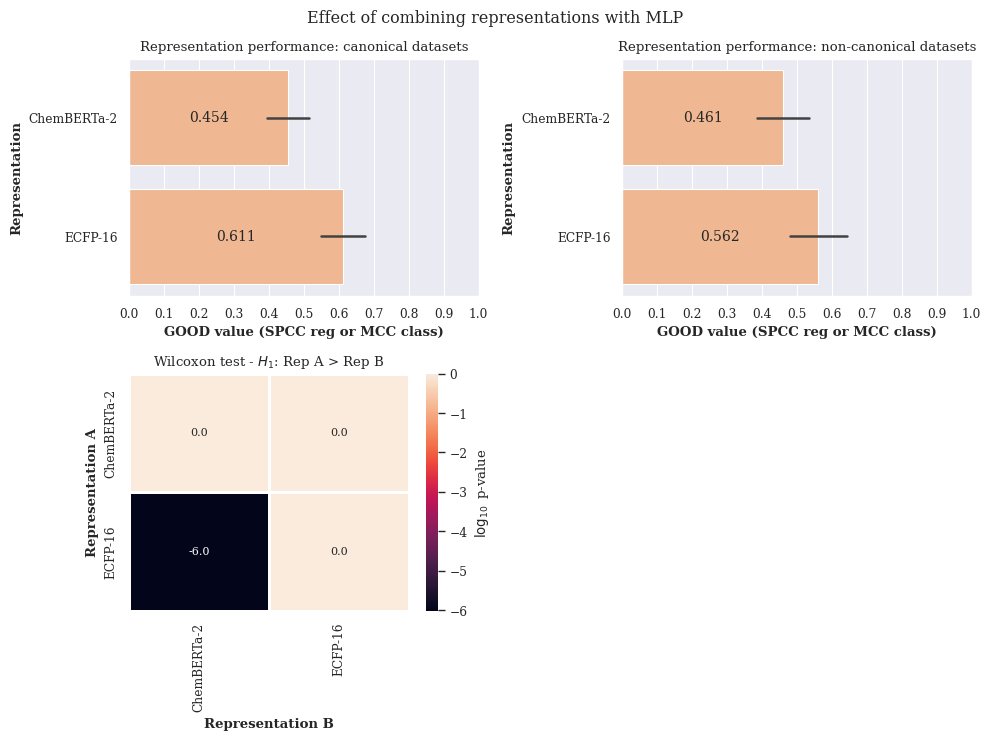

In [8]:
from scipy.stats import kruskal, kruskal, wilcoxon
import matplotlib.patches as mpatches

dir = '../../Results/mlp'
# combinations = [sim_metric + ' - ' + fp
#                 for sim_metric in SIM_METRICS_FANCY
#                 for fp in FINGERPRINTS_FANCY] + ['MAPc - Jaccard']
df = pd.DataFrame()

for file in os.listdir(dir):
    if 'mmseqs' in file:
        print(file)
        continue
    path = os.path.join(dir, file)
    tmp_df = pd.read_csv(path)
    tmp_df['model'] = file.split('_')[1]
    tmp_df['pre_pca'] = float(file.split('_')[3])
    tmp_df['post_pca'] = float(file.split('_')[5])
    tmp_df['dataset'] = file.split('_')[0]
    tmp_df['rep'] = file.split('_')[6][:-4]

    df = pd.concat([df, tmp_df])
    df = df[df.threshold != 'random']


df.threshold = df.threshold.map(float)
all_df = df.copy()

all_proto_df = []
for idx, dataset in enumerate(dataset_order):
    df = all_df[all_df['dataset'] == dataset].copy()
    # print(dataset)
    if dataset in REGRESSION:
        metric = 'spcc'
    else:
        metric = 'mcc'
    num_subplots = 3
    new_df = []
    for model in all_df.model.unique():
        for seed in all_df.seed.unique():
            for rep in all_df.rep.unique():
                tmp_df = df[(df.model == model) & (df.seed == seed) & (df.rep == rep)]
                if len(tmp_df) < 1:
                    continue
                new_df.append(
                    {'rep': rep, 'seed': seed, 'model': model, 'GOOD': tmp_df[metric].mean(),
                     'dataset': dataset}
                )
                all_proto_df.append(new_df[-1])

df = pd.DataFrame(all_proto_df)


def get_stats(df: pd.DataFrame, order: list):
    g_df = df.groupby('rep')
    groups = {}
    for n, mini_df in g_df:
        groups[n] = mini_df['GOOD'].to_numpy()
    names = {name: idx for idx, name in enumerate(order)}
    mtx = np.ones((len(groups), len(groups)))
    for pair1 in order:
        for pair2 in order:
            if pair1 == pair2:
                continue    
            if len(groups[pair1]) != len(groups[pair2]):
                value = 2
            else:
                value = wilcoxon(
                    groups[pair1], groups[pair2],
                    alternative='greater'
                )[1]
            mtx[names[pair1], names[pair2]] = value
    # Bonferroni correction
    # mtx = mtx > 0.05 / len(groups.keys())
    return groups, mtx


fancy_rep = {
    'esm2-8m': 'ESM2 8M',
    'esm2-8m,ecfp': 'ESM2 8M+ECFP-16',
    'esm2-8m,prot-t5-xl': 'ESM2 8M+Prot-T5-XL',
    'esm2-8m,chemberta': 'ESM2 8M+ChemBERTa-2',
    'pepclm,ecfp': 'PeptideCLM+ECFP-16',
    'chemberta': "ChemBERTa-2",
    'ecfp': "ECFP-16",
    'ecfp,chemberta': 'ChemBERTa-2+ECFP-16',
    'pepclm,chemberta': 'PeptideCLM+ChemBERTa-2',
    'molformer,chemberta': "Molformer-XL+ChemBERTa-2"
}

df = df[df.model == 'mlp']
df.rep = df.rep.map(fancy_rep)


all_df = df[df.dataset.map(lambda x: x.startswith("c-"))]
means = all_df.groupby('rep')['GOOD'].mean()
names = [n for n, g in all_df.groupby('rep')]
order = np.argsort(means)
names = [names[i] for i in order]

plt.gcf().set_size_inches(10, 7.5)
sns.set_theme('paper')
plt.rcParams.update({'font.family': 'serif',
            })
                    #  'mathtext.default': 'regular'})
plt.subplots_adjust(top=0.8)

plt.subplot(2, 2, 1)
plt.title('Representation performance: canonical datasets')
ax = sns.barplot(all_df, x='GOOD', y='rep', hue='model',
                 order=names, palette=[sns.color_palette('pastel')[1]],
                    errorbar='se',
                    # whis=(0, 100),
                    )
plt.xlabel(f"GOOD value (SPCC reg or MCC class)",
           fontdict={"weight": "bold"})
plt.ylabel(f'Representation',
           fontdict={"weight": "bold"})
plt.xlim(0., 1)
try:
    ax.bar_label(ax.containers[0], fontsize=10, label_type='center', fmt='%.3f')
    if len(ax.containers) > 1:        
        ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.3f')
    # plt.legend(title='Model', bbox_to_anchor=(1, 1))

except:
    pass

ax.get_legend().remove()

plt.locator_params(axis='x', nbins=10)


groups, mtx = get_stats(all_df, names)
# Kruskal-Wallis test
p_value = kruskal(*list(groups.values()))[1]
if p_value > 0.05:
    print(p_value)
    print("There is no difference between representation methods with canonical datasets")
    mtx = None
else:
    print("There is significant difference between representation methods with canonical datasets")

if mtx is not None:
    plt.subplot(2, 2, 3)
    mtx = np.log10(mtx)
    mtx[mtx > -0.1] = 0
    print(mtx)
    sns.heatmap(mtx, xticklabels=names,
            yticklabels=names,
            annot=True,
            cbar=True,
            cbar_kws={'label': r'$\log_{10}$ p-value'},
            annot_kws={"size": 8},
            linewidths=1,
            fmt=".1f")
    psig = 0.05 / len(names)

    plt.ylabel('Representation A',
            fontdict={"weight": "bold"})
    plt.xlabel('Representation B',
            fontdict={"weight": "bold"})
    plt.xticks(rotation=90)
    plt.title(r"Wilcoxon test - $H_1$: Rep A > Rep B")

all_df = df[df.dataset.map(lambda x: x.startswith("nc-"))]
means = all_df.groupby('rep')['GOOD'].mean()
names = [n for n, g in all_df.groupby('rep')]
order = np.argsort(means)
names = [names[i] for i in order]

plt.subplot(2, 2, 2)
plt.title('Representation performance: non-canonical datasets')
ax = sns.barplot(all_df, x='GOOD', y='rep', hue='model',
                 order=names, palette=[sns.color_palette('pastel')[1]],
                    errorbar='se',
                    # whis=(0, 100),
                    )
plt.xlabel(f"GOOD value (SPCC reg or MCC class)",
           fontdict={"weight": "bold"})
plt.ylabel(f'Representation',
           fontdict={"weight": "bold"})
plt.xlim(0., 1)
try:
    ax.bar_label(ax.containers[0], fontsize=10, label_type='center', fmt='%.3f')
    if len(ax.containers) > 1:        
        ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.3f')
    # plt.legend(title='Model', bbox_to_anchor=(1, 1))

except:
    pass

ax.get_legend().remove()

plt.locator_params(axis='x', nbins=10)

groups, mtx = get_stats(all_df, names)
# Kruskal-Wallis test
p_value = kruskal(*list(groups.values()))[1]

if p_value > 0.05:
    print(p_value)
    print("There is no difference between representation methods with non-canonical datasets")

else:
    print("There is significant difference between representation methods with non-canonical datasets")
    plt.subplot(2, 2, 4)
    mtx = np.log10(mtx)
    mtx[mtx > -0.1] = 0
    sns.heatmap(mtx, xticklabels=names,
                yticklabels=names,
                annot=True, cbar=True,
                cbar_kws={'label': r'$\log_{10}$ p-value'},
                annot_kws={"size": 10},
                linewidths=1,
                fmt=".1f")
    plt.ylabel('Representation A',
            fontdict={"weight": "bold"})
    plt.xlabel('Representation B',
            fontdict={"weight": "bold"})
    plt.xticks(rotation=90)
    plt.title(r"Wilcoxon test - $H_1$: Rep A > Rep B")

plt.suptitle('Effect of combining representations with MLP')
plt.tight_layout()
plt.savefig('si_figures/mlp.png', dpi=DPI, bbox_inches='tight')

## 8. Joint modelling

In [2]:
plt.gcf().set_size_inches(7, 9)
sns.set_theme('paper')
plt.rcParams.update({'font.family': 'serif',
            })

dirs = ['../../Results/joint', '../../Results/canonical', '../../Results/non-canonical']
data, data_2 = [], []

dataset_fancy = {
    "binding": "Protein-peptide\nbinding affinity",
    "cpp": "Cell penetration",
    'antiviral': "Antiviral",
    "antibacterial": "Antibacterial"
}
for dir in dirs:
    for file in os.listdir(dir):
        dataset = file.split('_')[0]
        rep = file.split('_')[6][:-4]
        path = os.path.join(dir, file)
        experiment = dir.split("/")[-1][0].upper() + dir.split("/")[-1][1:]
        if rep != 'chemberta':
            continue

        tmp_df = pd.read_csv(path)
        tmp_df['model'] = file.split('_')[1]
        tmp_df['pre_pca'] = float(file.split('_')[3])
        tmp_df['post_pca'] = float(file.split('_')[5])
        tmp_df['dataset'] = dataset
        tmp_df['rep'] = rep
        tmp_df['experiment'] = experiment

        if dataset == 'binding':
            metric = 'spcc'
        else:
            metric = 'mcc'

        data.append(
            {
                'dataset': dataset_fancy[dataset],
                'AU-GOOD': f"{tmp_df[tmp_df.threshold != 'random'][f'{metric}_c'].mean():.2g}±{tmp_df[tmp_df.threshold != 'random'][f'{metric}_c'].std():.1g}",
                "Test set": "Canonical",
                "Experiment": experiment
            }
        )
        data.append(
            {
                'dataset': dataset_fancy[dataset],
                'AU-GOOD': f"{tmp_df[tmp_df.threshold != 'random'][f'{metric}_nc'].mean():.2g}±{tmp_df[tmp_df.threshold != 'random'][f'{metric}_nc'].std():.1g}",
                "Test set": "Non-canonical",
                "Experiment": experiment

            }
        )
        for m in tmp_df[f'{metric}_c']:
            data_2.append({
                'dataset': dataset_fancy[dataset],
                "AU-GOOD": m,
                "Test set": "Canonical",
                "Experiment": experiment

            })
        for m in tmp_df[f'{metric}_nc']:
            data_2.append({
                'dataset': dataset_fancy[dataset],
                "AU-GOOD": m,
                "Test set": "Non-canonical",
                "Experiment": experiment

            })

df = pd.DataFrame(data_2)

for n, g_df in df.groupby("Experiment"):
    print(n, "canonical", f"Mean: {g_df[g_df['Test set'] == 'Canonical']['AU-GOOD'].mean()} - Std: {g_df[g_df['Test set'] == 'Canonical']['AU-GOOD'].std()}")
    print(n, "non-canonical", f"Mean: {g_df[g_df['Test set'] == 'Non-canonical']['AU-GOOD'].mean()} - Std: {g_df[g_df['Test set'] == 'Non-canonical']['AU-GOOD'].std()}")

for idx, (dataset, g_df) in enumerate(df.groupby("dataset")):
    plt.subplot(len(df['dataset'].unique()), 1, idx+1)
    ax = sns.barplot(g_df, x='Experiment', y='AU-GOOD', hue='Test set', palette=sns.color_palette("pastel"))
    try:
        ax.bar_label(ax.containers[0], fontsize=10, label_type='center', fmt='%.3f')
        if len(ax.containers) > 1:        
            ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.3f')
    except:
        pass
    plt.title(dataset, fontdict={"weight": "bold"})
    plt.xlabel("Training dataset", fontdict={"weight": "bold"})
    plt.ylabel("GOOD values of\nMCC (class) or SPCC (reg)",
            fontdict={"weight": "bold"})
    plt.legend(title="Test set", bbox_to_anchor=(1, 1))
    leg = ax.get_legend()
    plt.setp(leg.get_title(), weight='bold')

    plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("si_figures/joint_modelling.png", bbox_inches='tight', dpi=DPI)
plt.close()

plt.gcf().set_size_inches(7, 3)

ax = sns.barplot(df, x='Experiment', y='AU-GOOD', hue='Test set', palette=sns.color_palette("pastel"))
try:
    ax.bar_label(ax.containers[0], fontsize=10, label_type='center', fmt='%.3f')
    if len(ax.containers) > 1:        
        ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.3f')
except:
    pass
for n, g_df in df.groupby("Experiment"):
    print(n, "canonical", f"Mean: {g_df[g_df['Test set'] == 'Canonical']['AU-GOOD'].mean()} - Std: {g_df[g_df['Test set'] == 'Canonical']['AU-GOOD'].std()}")
    print(n, "non-canonical", f"Mean: {g_df[g_df['Test set'] == 'Non-canonical']['AU-GOOD'].mean()} - Std: {g_df[g_df['Test set'] == 'Non-canonical']['AU-GOOD'].std()}")

plt.suptitle("Joint modelling of canonical and non-canonical peptides",
        fontdict={"weight": "bold"})
plt.legend(title="Test set", bbox_to_anchor=(1, 1))
leg = ax.get_legend()
plt.setp(leg.get_title(), weight='bold')

plt.tight_layout()
plt.savefig("figures/joint_modelling.png", bbox_inches='tight', dpi=DPI)
plt.close()

Canonical canonical Mean: 0.6258726911710473 - Std: 0.2652196851161431
Canonical non-canonical Mean: 0.16636953918310488 - Std: 0.1399348185508534
Joint canonical Mean: 0.6110954811452552 - Std: 0.2731722199331464
Joint non-canonical Mean: 0.6404403558973393 - Std: 0.2675594159557274
Non-canonical canonical Mean: 0.08807413444804611 - Std: 0.08029929195484206
Non-canonical non-canonical Mean: 0.7910942579669247 - Std: 0.13976713955833067


/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/ipykernel_18316/1017783632.py:79: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(g_df, x='Experiment', y='AU-GOOD', hue='Test set', palette=sns.color_palette("pastel"))
/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/ipykernel_18316/1017783632.py:79: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(g_df, x='Experiment', y='AU-GOOD', hue='Test set', palette=sns.color_palette("pastel"))
/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/ipykernel_18316/1017783632.py:79: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(g_df, x='Experiment', y='AU-GOOD', hue='Test set', palette=sns.color_palette("pastel"))
/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/ipykernel_18316/1017783632.py:79: UserWarning: The palette list has more values (10) than needed

Canonical canonical Mean: 0.6258726911710473 - Std: 0.2652196851161431
Canonical non-canonical Mean: 0.16636953918310488 - Std: 0.1399348185508534
Joint canonical Mean: 0.6110954811452552 - Std: 0.2731722199331464
Joint non-canonical Mean: 0.6404403558973393 - Std: 0.2675594159557274
Non-canonical canonical Mean: 0.08807413444804611 - Std: 0.08029929195484206
Non-canonical non-canonical Mean: 0.7910942579669247 - Std: 0.13976713955833067


Canonical canonical Mean: 0.8247379532651448 - Std: 0.10590713431089917
Canonical non-canonical Mean: 0.14800883903875003 - Std: 0.1802305325342588
Joint canonical Mean: 0.8311147719143743 - Std: 0.10759063096732509
Joint non-canonical Mean: 0.8320815278219941 - Std: 0.10426803903746132
Non-canonical canonical Mean: 0.058670429139082415 - Std: 0.0787670969804302
Non-canonical non-canonical Mean: 0.8304418647416331 - Std: 0.11907327246749191


/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/ipykernel_18316/2907153704.py:86: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(g_df, x='Experiment', y='AU-GOOD', hue='Test set', palette=sns.color_palette("pastel"))
/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/ipykernel_18316/2907153704.py:86: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(g_df, x='Experiment', y='AU-GOOD', hue='Test set', palette=sns.color_palette("pastel"))
/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/ipykernel_18316/2907153704.py:86: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(g_df, x='Experiment', y='AU-GOOD', hue='Test set', palette=sns.color_palette("pastel"))
/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/ipykernel_18316/2907153704.py:86: UserWarning: The palette list has more values (10) than needed

Canonical canonical Mean: 0.8247379532651448 - Std: 0.10590713431089917
Canonical non-canonical Mean: 0.14800883903875003 - Std: 0.1802305325342588
Joint canonical Mean: 0.8311147719143743 - Std: 0.1075906309673251
Joint non-canonical Mean: 0.8320815278219941 - Std: 0.10426803903746132
Non-canonical canonical Mean: 0.058670429139082415 - Std: 0.0787670969804302
Non-canonical non-canonical Mean: 0.8304418647416331 - Std: 0.11907327246749191


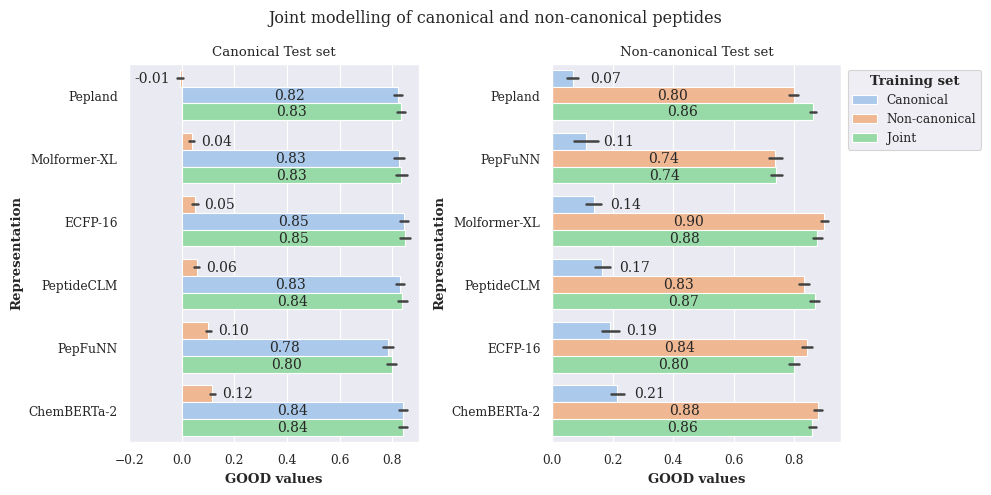

In [11]:
plt.gcf().set_size_inches(7, 9)
sns.set_theme('paper')
plt.rcParams.update({'font.family': 'serif',
            })

dirs = ['../../Results/joint', '../../Results/canonical', '../../Results/non-canonical']
data, data_2 = [], []

dataset_fancy = {
    "binding": "Protein-peptide\nbinding affinity",
    "cpp": "Cell penetration",
    'antiviral': "Antiviral",
    "antibacterial": "Antibacterial"
}
for dir in dirs:
    for file in os.listdir(dir):

        dataset = file.split('_')[0]
        rep = file.split('_')[6][:-4]
        path = os.path.join(dir, file)
        experiment = dir.split("/")[-1][0].upper() + dir.split("/")[-1][1:]
        model = file.split('_')[1]
        if model != 'lightgbm':
            continue
        # if rep != 'chemberta':
        #     continue

        tmp_df = pd.read_csv(path)
        tmp_df['model'] = file.split('_')[1]
        tmp_df['pre_pca'] = float(file.split('_')[3])
        tmp_df['post_pca'] = float(file.split('_')[5])
        tmp_df['dataset'] = dataset
        tmp_df['rep'] = rep
        tmp_df['experiment'] = experiment

        if dataset == 'binding':
            metric = 'spcc'
        else:
            metric = 'mcc'

        data.append(
            {
                'dataset': dataset_fancy[dataset],
                'AU-GOOD': f"{tmp_df[tmp_df.threshold != 'random'][f'{metric}_c'].mean():.2g}±{tmp_df[tmp_df.threshold != 'random'][f'{metric}_c'].std():.1g}",
                "Test set": "Canonical",
                "Experiment": experiment,
                "Representation": rep
            }
        )
        data.append(
            {
                'dataset': dataset_fancy[dataset],
                'AU-GOOD': f"{tmp_df[tmp_df.threshold != 'random'][f'{metric}_nc'].mean():.2g}±{tmp_df[tmp_df.threshold != 'random'][f'{metric}_nc'].std():.1g}",
                "Test set": "Non-canonical",
                "Experiment": experiment,
                "Representation": rep
            }
        )
        for m in tmp_df[f'{metric}_c']:
            data_2.append({
                'dataset': dataset_fancy[dataset],
                "AU-GOOD": m,
                "Test set": "Canonical",
                "Experiment": experiment,
                "Representation": fancy_rep[rep]

            })
        for m in tmp_df[f'{metric}_nc']:
            data_2.append({
                'dataset': dataset_fancy[dataset],
                "AU-GOOD": m,
                "Test set": "Non-canonical",
                "Experiment": experiment,
                "Representation": fancy_rep[rep]

            })

df = pd.DataFrame(data_2)

for n, g_df in df.groupby("Experiment"):
    print(n, "canonical", f"Mean: {g_df[g_df['Test set'] == 'Canonical']['AU-GOOD'].mean()} - Std: {g_df[g_df['Test set'] == 'Canonical']['AU-GOOD'].std()}")
    print(n, "non-canonical", f"Mean: {g_df[g_df['Test set'] == 'Non-canonical']['AU-GOOD'].mean()} - Std: {g_df[g_df['Test set'] == 'Non-canonical']['AU-GOOD'].std()}")

for idx, (dataset, g_df) in enumerate(df.groupby("dataset")):
    plt.subplot(len(df['dataset'].unique()), 1, idx+1)
    ax = sns.barplot(g_df, x='Experiment', y='AU-GOOD', hue='Test set', palette=sns.color_palette("pastel"))
    try:
        ax.bar_label(ax.containers[0], fontsize=10, label_type='center', fmt='%.3f')
        if len(ax.containers) > 1:        
            ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.3f')
    except:
        pass
    plt.title(dataset, fontdict={"weight": "bold"})
    plt.xlabel("Training dataset", fontdict={"weight": "bold"})
    plt.ylabel("GOOD values of\nMCC (class) or SPCC (reg)",
            fontdict={"weight": "bold"})
    plt.legend(title="Test set", bbox_to_anchor=(1, 1))
    leg = ax.get_legend()
    plt.setp(leg.get_title(), weight='bold')

    plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("si_figures/joint_modelling.png", bbox_inches='tight', dpi=DPI)
plt.close()

plt.gcf().set_size_inches(10, 5)

plt.subplot(1, 2, 1)
plt.title("Canonical Test set")
df.sort_values("AU-GOOD", ascending=True, inplace=True)
ax = sns.barplot(
    df[df['Test set'] == 'Canonical'],
    y='Representation',
    x='AU-GOOD',
    hue='Experiment',
    palette=[sns.color_palette("pastel")[1], sns.color_palette("pastel")[0], sns.color_palette("pastel")[2]],
    hue_order=['Non-canonical', 'Canonical', 'Joint'],
    order=['Pepland', 'Molformer-XL', 'ECFP-16', 'PeptideCLM', 'PepFuNN', 'ChemBERTa-2']
)
ax.legend().set_visible(False)
plt.xlabel("GOOD values", fontdict={"weight": "bold"})
plt.ylabel("Representation", fontdict={"weight": "bold"})
try:
    ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', padding=7, fmt='%.2f')
    ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.2f')
    ax.bar_label(ax.containers[2], fontsize=10, label_type='center', fmt='%.2f')

except:
    pass
plt.xlim(-0.2, 0.9)
plt.subplot(1, 2, 2)
plt.title("Non-canonical Test set")
ax = sns.barplot(
    df[df['Test set'] == 'Non-canonical'],
    y='Representation',
    x='AU-GOOD',
    hue='Experiment',
    palette=sns.color_palette("pastel"),
    hue_order=['Canonical', 'Non-canonical', 'Joint'],
    order=['Pepland', 'PepFuNN', 'Molformer-XL', 'PeptideCLM', 'ECFP-16', 'ChemBERTa-2']

)
ax.legend().set_visible(False)
plt.xlabel("GOOD values", fontdict={"weight": "bold"})
plt.ylabel("Representation", fontdict={"weight": "bold"})

try:
    ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', padding=12, fmt='%.2f')
    ax.bar_label(ax.containers[1], fontsize=10, label_type='center', fmt='%.2f')
    ax.bar_label(ax.containers[2], fontsize=10, label_type='center', fmt='%.2f')
except:
    pass

for n, g_df in df.groupby("Experiment"):
    print(n, "canonical", f"Mean: {g_df[g_df['Test set'] == 'Canonical']['AU-GOOD'].mean()} - Std: {g_df[g_df['Test set'] == 'Canonical']['AU-GOOD'].std()}")
    print(n, "non-canonical", f"Mean: {g_df[g_df['Test set'] == 'Non-canonical']['AU-GOOD'].mean()} - Std: {g_df[g_df['Test set'] == 'Non-canonical']['AU-GOOD'].std()}")

plt.suptitle("Joint modelling of canonical and non-canonical peptides")
plt.legend(title="Training set", bbox_to_anchor=(1, 1))
leg = ax.get_legend()
plt.setp(leg.get_title(), weight='bold')

plt.tight_layout()
plt.savefig("si_figures/joint_modelling_complete.png", bbox_inches='tight', dpi=DPI)
# plt.close()

In [23]:
df = pd.DataFrame(data)
for experiment in ['Canonical', 'Non-canonical', 'Joint']:
    tmp_df = df[df["Experiment"] == experiment]
    tmp_df.to_latex(f"tables/{experiment}.md")
